## Imports and dataset

In [1]:
from src.models.optimized_bnn import BayesianNN, DBNN
from src.models.deep_ensemble import DeepEnsemble
from src.attacks.distr_attacks_bnn_wasserstein import wasserstein_attack

from src.utils2 import plot_ppds

import numpy as np
import pandas as pd
import jax
import numpyro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = DBNN(input_dim=X_train.shape[1], hidden_units=30)
try:
    model.load('../src/models/weights/30dbnn2')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train,
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/weights/30dbnn')

In [8]:
# Attack example
x = X_test[17,:].copy()
x = jax.numpy.array(x.reshape(1,-1))
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 0.5 * std)
x_adv_distr, x_adv_values = wasserstein_attack(model, x, appd, jax.random.PRNGKey(42), epsilon=.2, 
                                               num_samples=500, inner_iter=200, inner_lr=0.01, max_iter=1, outer_lr=0.01)

Converged in 1 iterations.


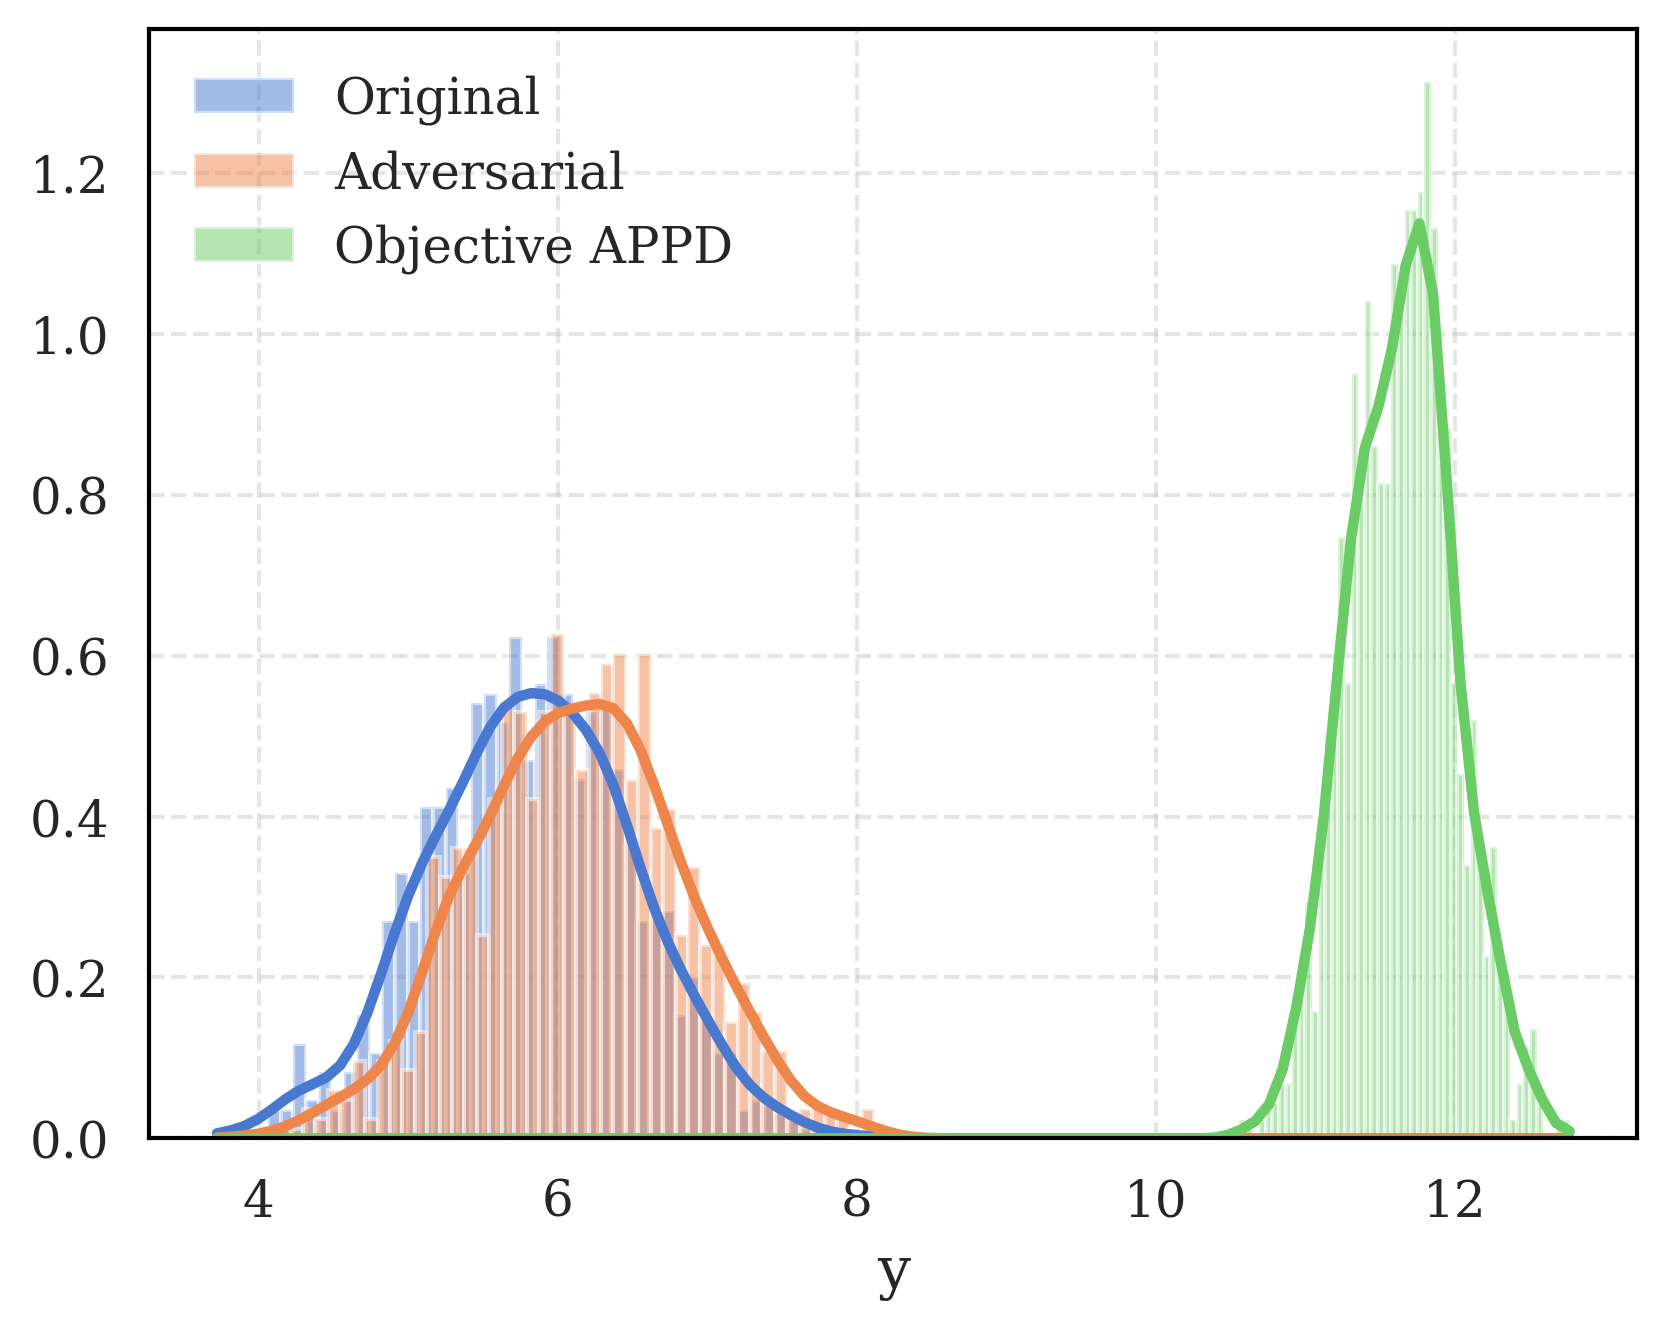

In [9]:
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), appd, num_samples=1000)

# Deep ensembles

In [10]:
# Fit the model
model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=30, num_models=20)
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/wine'
try:
    model.load(path)
except FileNotFoundError:
    print('Not model found, fitting the model') 
    model.fit(
        X_train,
        y_train,
        300, 
        batch_size=128
    )
    model.save(path)

In [11]:
# Attack example
x = X_test[17,:].copy()
x = jax.numpy.array(x.reshape(1,-1))
std = model.sample_predictive_distribution(x, 10).std()
mu = model.sample_predictive_distribution(x, 10).mean()
appd = numpyro.distributions.Normal(0.5 + mu, 0.5 * std)
x_adv_distr, x_adv_values = wasserstein_attack(model, x, appd, jax.random.PRNGKey(42), epsilon=.2, 
                                               num_samples=model.num_models, inner_iter=200, inner_lr=0.01, max_iter=100, outer_lr=1e-3, patience_eps=1e-4)

Converged in 100 iterations.


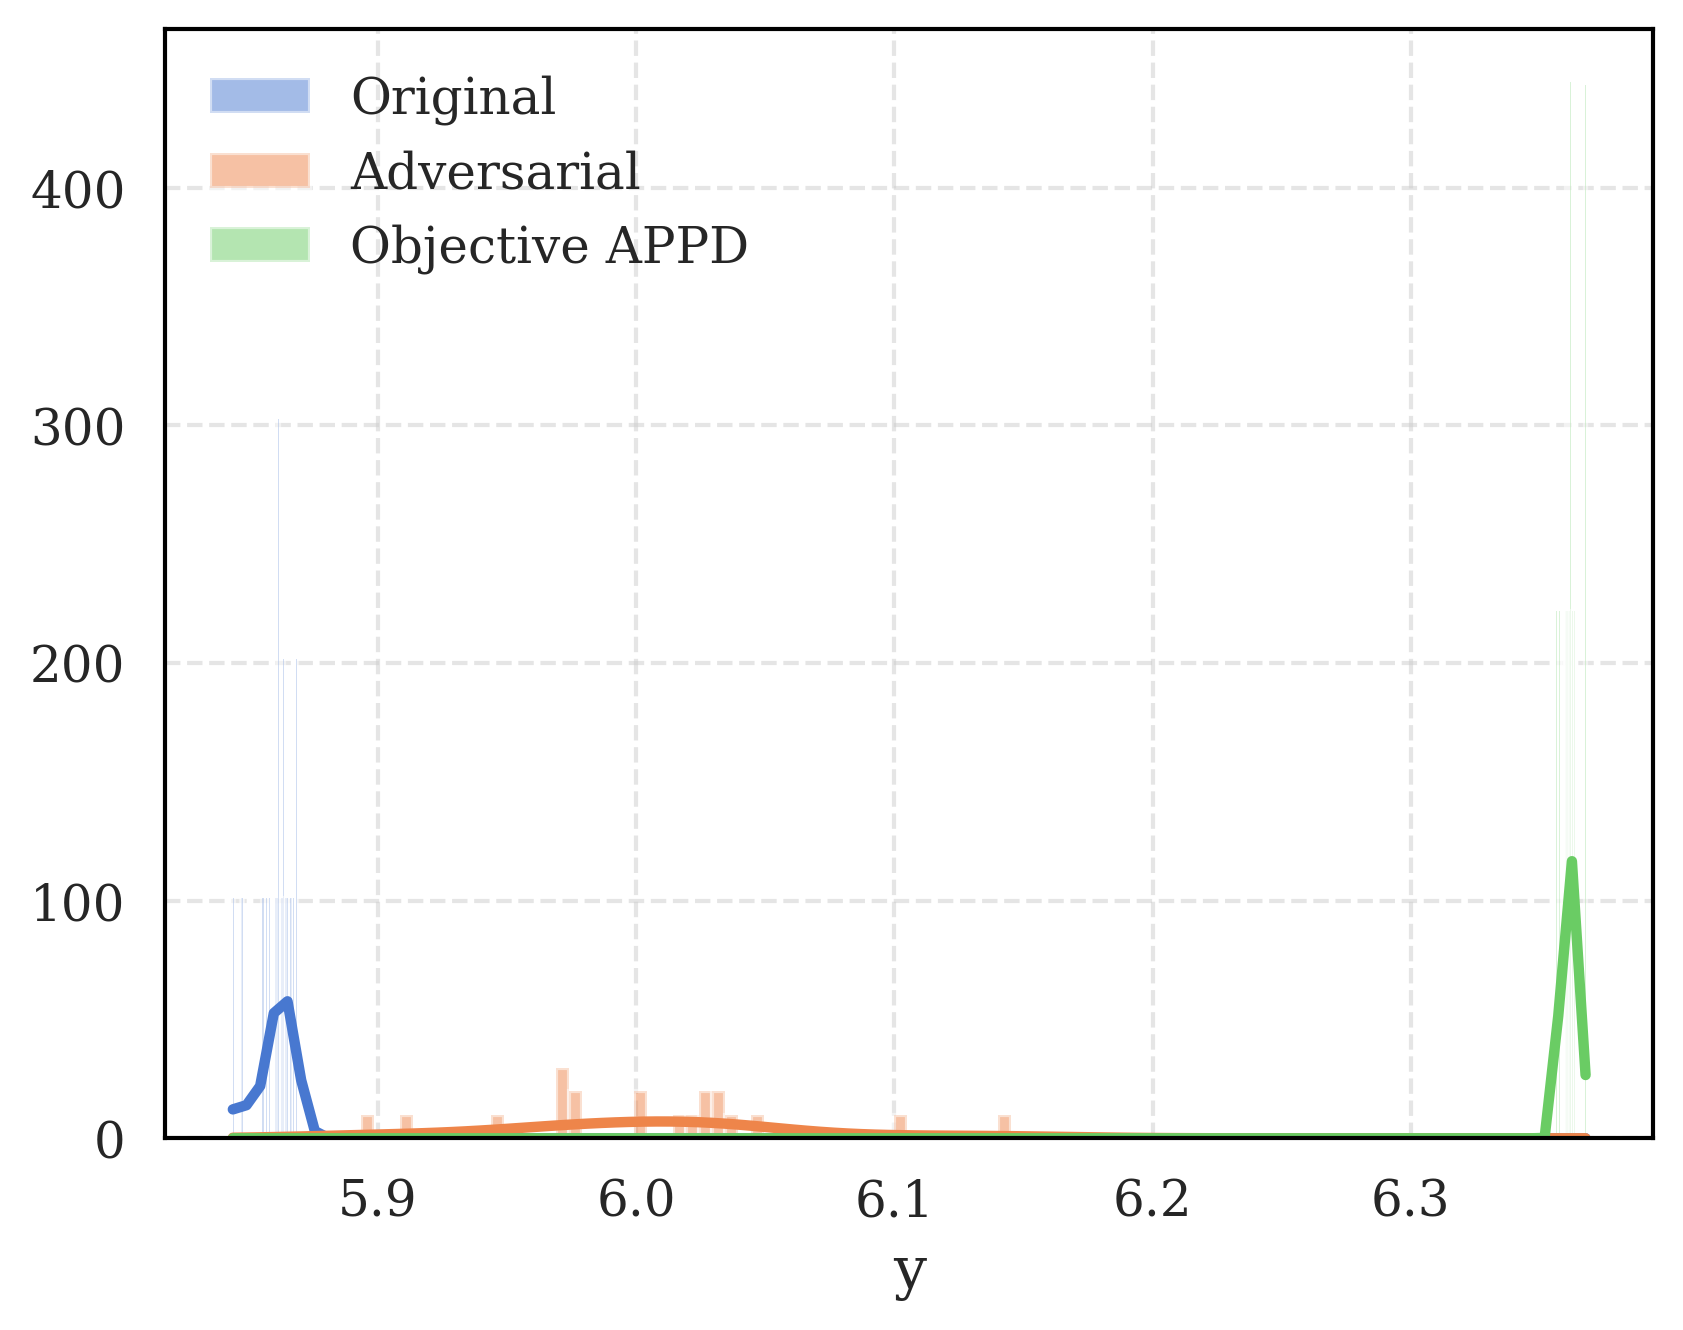

In [12]:
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), appd, num_samples=20)

## MNIST - Reproducing Deep Ensemble results

In [13]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = X / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [ ]:
# Fit the model
model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=200, output_dim=10, num_models=20, model_type='mnist_mlp')
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/mnist'
try:
    model.load(path)
except FileNotFoundError:
    print('Not model found, fitting the model') 
    model.fit(
        X_train,
        y_train,
        300,
        batch_size=2048
    )
    model.save(path)

Not model found, fitting the model
Training model... 1
Loss: 0.2898
Loss: 0.0001
